In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('Data/3_final_imaging_data.xlsx')

Since SPECT/CT and Sestamibi are both nuclear scans, we are combining them into a single column

In [2]:
# create a function to combine the SPECT/CT and Sestamibi 
def combine_nuclear_scans(row):
    
    # initialize the modality columns 
    spect = row['SPECT/CT']
    sestamibi = row['Sestamibi']
    
    # remove missing entries
    spect_missing = pd.isnull(spect) or spect == 'No Scan'
    sestamibi_missing = pd.isnull(sestamibi) or sestamibi == 'No Scan'
    if spect_missing and sestamibi_missing:
        return 'No SPECT/CT or Sestamibi Recorded'
    
    # check if both scans are present 
    if not spect_missing and not sestamibi_missing:
        return f"SPECT/CT: {spect} | Sestamibi: {sestamibi}"
    
    # check for spect scans 
    if not spect_missing:
        return f"SPECT/CT: {spect}"
    
    # otherwise return the sestamibi scan 
    return f"Sestamibi: {sestamibi}"

In [3]:
# apply this function across the whole dataset and create the new column 
preop_imaging_df['SPECT/CT-Sestamibi'] = preop_imaging_df.apply(combine_nuclear_scans, axis=1)

# filter for only the non-localizing nuclear scans 
neg_nuclear = preop_imaging_df[preop_imaging_df['SPECT/CT-Sestamibi'].str.contains('Non-localizing')]

# create a function that checks defines localization 
def is_localizing(scan):
    if pd.isnull(scan):
        return False
    scan = scan.strip()
    return scan not in ['No Scan', 'Non-localizing']

In [4]:
# avoid the the copyright warning
neg_nuclear = neg_nuclear.copy() 

# out of the negative nuclear scans, filter for positive 4D CT
neg_nuclear['4D CT Positive'] = neg_nuclear['4D CT Scan'].apply(is_localizing)

# count total and positive cases 
total_neg_nuclear = neg_nuclear.shape[0]
num_4dct_positive = neg_nuclear['4D CT Positive'].sum()

print(f"Out of {total_neg_nuclear} nuclear-negative cases, {num_4dct_positive} had a localizing 4D CT scan.")


Out of 112 nuclear-negative cases, 54 had a localizing 4D CT scan.


**How accurate were these 4D CT scans?**

In [5]:
# filter to these 54 occurances
neg_nuclear_pos_4dct = neg_nuclear[neg_nuclear['4D CT Positive']]

# get the summary 
breakdown = neg_nuclear_pos_4dct['4D CT Scan Calculated Concordance'].value_counts()

# get percentages
breakdown_percent = breakdown / breakdown.sum() * 100

# combine count and percentage into a summary DataFrame
summary_df = pd.DataFrame({
    'Count': breakdown,
    'Percentage': breakdown_percent.round(1)
}).reset_index().rename(columns={'index': 'Concordance Type'})

print(summary_df)

  4D CT Scan Calculated Concordance  Count  Percentage
0                       Yes (Exact)     24        44.4
1            Incorrect Localization     19        35.2
2                        Yes (Side)     11        20.4


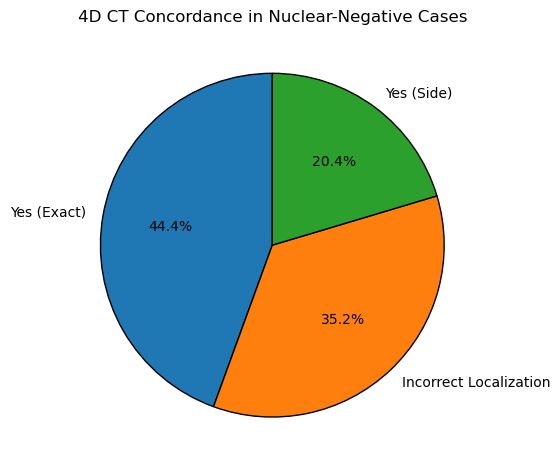

In [6]:
summary_df.set_index('4D CT Scan Calculated Concordance').plot.pie(
    y='Count',
    autopct='%1.1f%%',
    startangle=90,
    legend=False,
    ylabel='',
     wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)
plt.title('4D CT Concordance in Nuclear-Negative Cases')
plt.tight_layout()
plt.show()

**Out of the 112 negative nuclear scans, let's also see how often the corresponding 4D CT scan was negative**

In [26]:
# create a function that defines non-localizing
def is_non_localizing(scan):
    return pd.isnull(scan) or scan.strip() in ['No Scan', 'Non-localizing']

# apply this function
neg_nuclear['4D CT Non-localizing'] = neg_nuclear['4D CT Scan'].apply(is_non_localizing)

# calculate count and percentage
n_non_localizing = neg_nuclear['4D CT Non-localizing'].sum()
n_total = neg_nuclear.shape[0]
pct_non_localizing = (n_non_localizing / n_total) * 100

print(f"{n_non_localizing} out of {n_total} nuclear-negative patients also had non-localizing 4D CT scans.")
print(f"That’s {pct_non_localizing:.1f}% of the group.")

58 out of 112 nuclear-negative patients also had non-localizing 4D CT scans.
That’s 51.8% of the group.
